In [ ]:
!pip install tensorflow
!pip install opencv-python

!pip uninstall -y mediapipe numpy

!pip cache purge
!pip install numpy mediapipe --no-cache-dir --force-reinstall

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
Files removed: 0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 179.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 260.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.2/113.2 kB 227.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 198.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 185.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 190.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━

In [7]:
import numpy as np
import pandas as pd
import random
import time
import os
import scipy.stats

import matplotlib.pyplot as plt
from IPython.display import display, Image

import cv2
import mediapipe as mp
from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import load_model

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
base_dir = "/content/drive/MyDrive/sign_language_detection"

test_videos_path = os.path.join(base_dir, 'test_videos')
if not os.path.exists(test_videos_path):
    os.makedirs(test_videos_path)

DATA_PATH = os.path.join(base_dir, 'MP_Data')

In [ ]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [ ]:
actions = np.array(['Belajar','Berdiri','Duduk','Makan','Mandi',
                    'Melihat','Membaca','Menulis','Minum','Tidur'])

DATA_PATH = os.path.join(base_dir, 'MP_Data')
VIDEO_PATH = os.path.join(base_dir, 'videos')
os.makedirs(DATA_PATH, exist_ok=True)

In [12]:
sequence_length = 30

for action in actions:
    action_video_path = os.path.join(VIDEO_PATH, action)
    action_data_path = os.path.join(DATA_PATH, action)
    os.makedirs(action_data_path, exist_ok=True)

    for video_counter, video_file in enumerate(os.listdir(action_video_path)):
        print(f"\n▶ Processing {video_file}")

        full_video_path = os.path.join(action_video_path, video_file)
        cap = cv2.VideoCapture(full_video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Total frames: {total_frames}")

        if total_frames >= sequence_length:
            frame_indices = np.linspace(0, total_frames - 1, sequence_length, dtype=int)
        else:
            frame_indices = list(range(total_frames)) + [total_frames-1] * (sequence_length - total_frames)

        sequence_folder = os.path.join(action_data_path, str(video_counter))
        os.makedirs(sequence_folder, exist_ok=True)

        with mp.solutions.holistic.Holistic(
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        ) as holistic:

            for i, frame_index in enumerate(frame_indices):
                cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                ret, frame = cap.read()
                if not ret:
                    print(f"⚠ Could not read frame {frame_index}")
                    continue

                image, results = mediapipe_detection(frame, holistic)
                draw_styled_landmarks(image, results)
                keypoints = extract_keypoints(results)

                npy_path = os.path.join(sequence_folder, f"{i}.npy")
                np.save(npy_path, keypoints)
                print(f"✅ Saved to {npy_path}")

        cap.release()

Streaming output truncated to the last 5000 lines.
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/13.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/14.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/15.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/16.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/17.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/18.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/19.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/20.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/21.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/22.npy
✅ Saved to /content/drive/MyDrive/sign_language_detection/MP_Data/Melihat/23/23.npy
✅ Saved to /content/drive

In [13]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'Belajar': 0,
 'Berdiri': 1,
 'Duduk': 2,
 'Makan': 3,
 'Mandi': 4,
 'Melihat': 5,
 'Membaca': 6,
 'Menulis': 7,
 'Minum': 8,
 'Tidur': 9}

In [14]:
sequences, labels = [], []

for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    for sequence in np.array(os.listdir(action_path)).astype(int):
        window = []
        try:
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(action_path, str(sequence), f"{frame_num}.npy"))
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])
        except FileNotFoundError:
            print(f"⚠ Skipping incomplete sequence: {action}/{sequence}")
            continue

X = np.array(sequences)
y = to_categorical(labels).astype(int)

⚠ Skipping incomplete sequence: Belajar/14
⚠ Skipping incomplete sequence: Belajar/17
⚠ Skipping incomplete sequence: Berdiri/8
⚠ Skipping incomplete sequence: Makan/8
⚠ Skipping incomplete sequence: Makan/18
⚠ Skipping incomplete sequence: Melihat/15
⚠ Skipping incomplete sequence: Membaca/6
⚠ Skipping incomplete sequence: Menulis/0
⚠ Skipping incomplete sequence: Menulis/10
⚠ Skipping incomplete sequence: Minum/13


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (312, 30, 1662)
X_test shape: (17, 30, 1662)
y_train shape: (312, 10)
y_test shape: (17, 10)


In [16]:
# Set the directory where TensorBoard logs will be saved
log_dir = os.path.join('Logs')

# Create a TensorBoard callback to log training metrics (loss, accuracy, etc.)
# This allows you to visualize training progress in TensorBoard
tb_callback = TensorBoard(log_dir=log_dir)

# Build a sequential neural network model
model = Sequential()

# First LSTM layer with 64 units; returns sequences to feed into next LSTM
# Input shape is (30 time steps, 1662 features per frame)
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))

# Second LSTM layer with 128 units; also returns sequences
model.add(LSTM(128, return_sequences=True, activation='relu'))

# Third LSTM layer with 64 units; does not return sequences (only final output is passed on)
model.add(LSTM(64, return_sequences=False, activation='relu'))

# Fully connected dense layer with 64 units and ReLU activation
model.add(Dense(64, activation='relu'))

# Fully connected dense layer with 32 units and ReLU activation
model.add(Dense(32, activation='relu'))

# Output layer with number of units equal to number of actions (e.g., 3),
# and softmax activation for multi-class classification
model.add(Dense(actions.shape[0], activation='softmax'))

# Compile the model with the following settings:
# 'Adam' optimizer is used, which is an adaptive learning rate method commonly used in training deep learning models
model.compile(optimizer='Adam',
              # Use 'categorical_crossentropy' as the loss function, suitable for multi-class classification problems
              loss='categorical_crossentropy',
              # Track 'categorical_accuracy' during training to evaluate how well the model is classifying the correct action
              metrics=['categorical_accuracy'])

# Train the model using the training data
# X_train: Input data (sequences of keypoints)
# y_train: Target labels (one-hot encoded labels for the actions)
# epochs=200: The model will train for 200 epochs (iterations over the entire dataset)
# callbacks=[tb_callback]: This will use the TensorBoard callback to log training progress and metrics for visualization
model.fit(X_train, y_train, epochs=200, callbacks=[tb_callback])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - categorical_accuracy: 0.0655 - loss: 2.3240
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - categorical_accuracy: 0.1574 - loss: 2.3205
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - categorical_accuracy: 0.1624 - loss: 2.2835
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - categorical_accuracy: 0.1418 - loss: 2.2879
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - categorical_accuracy: 0.1139 - loss: 2.2733
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - categorical_accuracy: 0.1151 - loss: 2.2390
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - categorical_accuracy: 0.1736 - loss: 2.3609
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - categorical_accuracy: 0.1598 - loss: 2.2916
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - categorical_accuracy: 0.1951 - loss: 2.2834
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - categorical_accuracy: 0.1532 - loss: 2.2762
Epoch 11/

In [17]:
# Use the trained model to make predictions on the test data
# X_test: Input data (test set of sequences of keypoints)
# The model predicts the output (probabilities for each class) for each sample in the test set
y_pred = model.predict(X_test)

# Display the predictions (e.g., probabilities for each class for each test sample)
y_pred.shape

# Get the predicted action label for the 4th sample in the test set (index 3)
# np.argmax(res[3]) returns the index of the highest predicted probability (most likely class) for the 4th sample
# The index is used to retrieve the corresponding action label from the 'actions' array
actions[np.argmax(y_pred[5])]  # TODO: Change index to see other predictions


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 730ms/step


'Belajar'

In [18]:

# Get the true action label for the 4th sample in the test set (index 3)
# np.argmax(y_test[3]) returns the index of the highest value in the one-hot encoded true label for the 4th sample
# The index is used to retrieve the corresponding action label from the 'actions' array
actions[np.argmax(y_test[5])] # TODO: Change to the same index as the previous code block to see if the results match

'Melihat'

In [19]:
model_path = os.path.join(base_dir, 'my_model.keras')

model.save(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Confusion Matrices berhasil dihitung dan disimpan sebagai 'multilabel_confusion_matrices.png'

Overall Accuracy Score: 0.0000


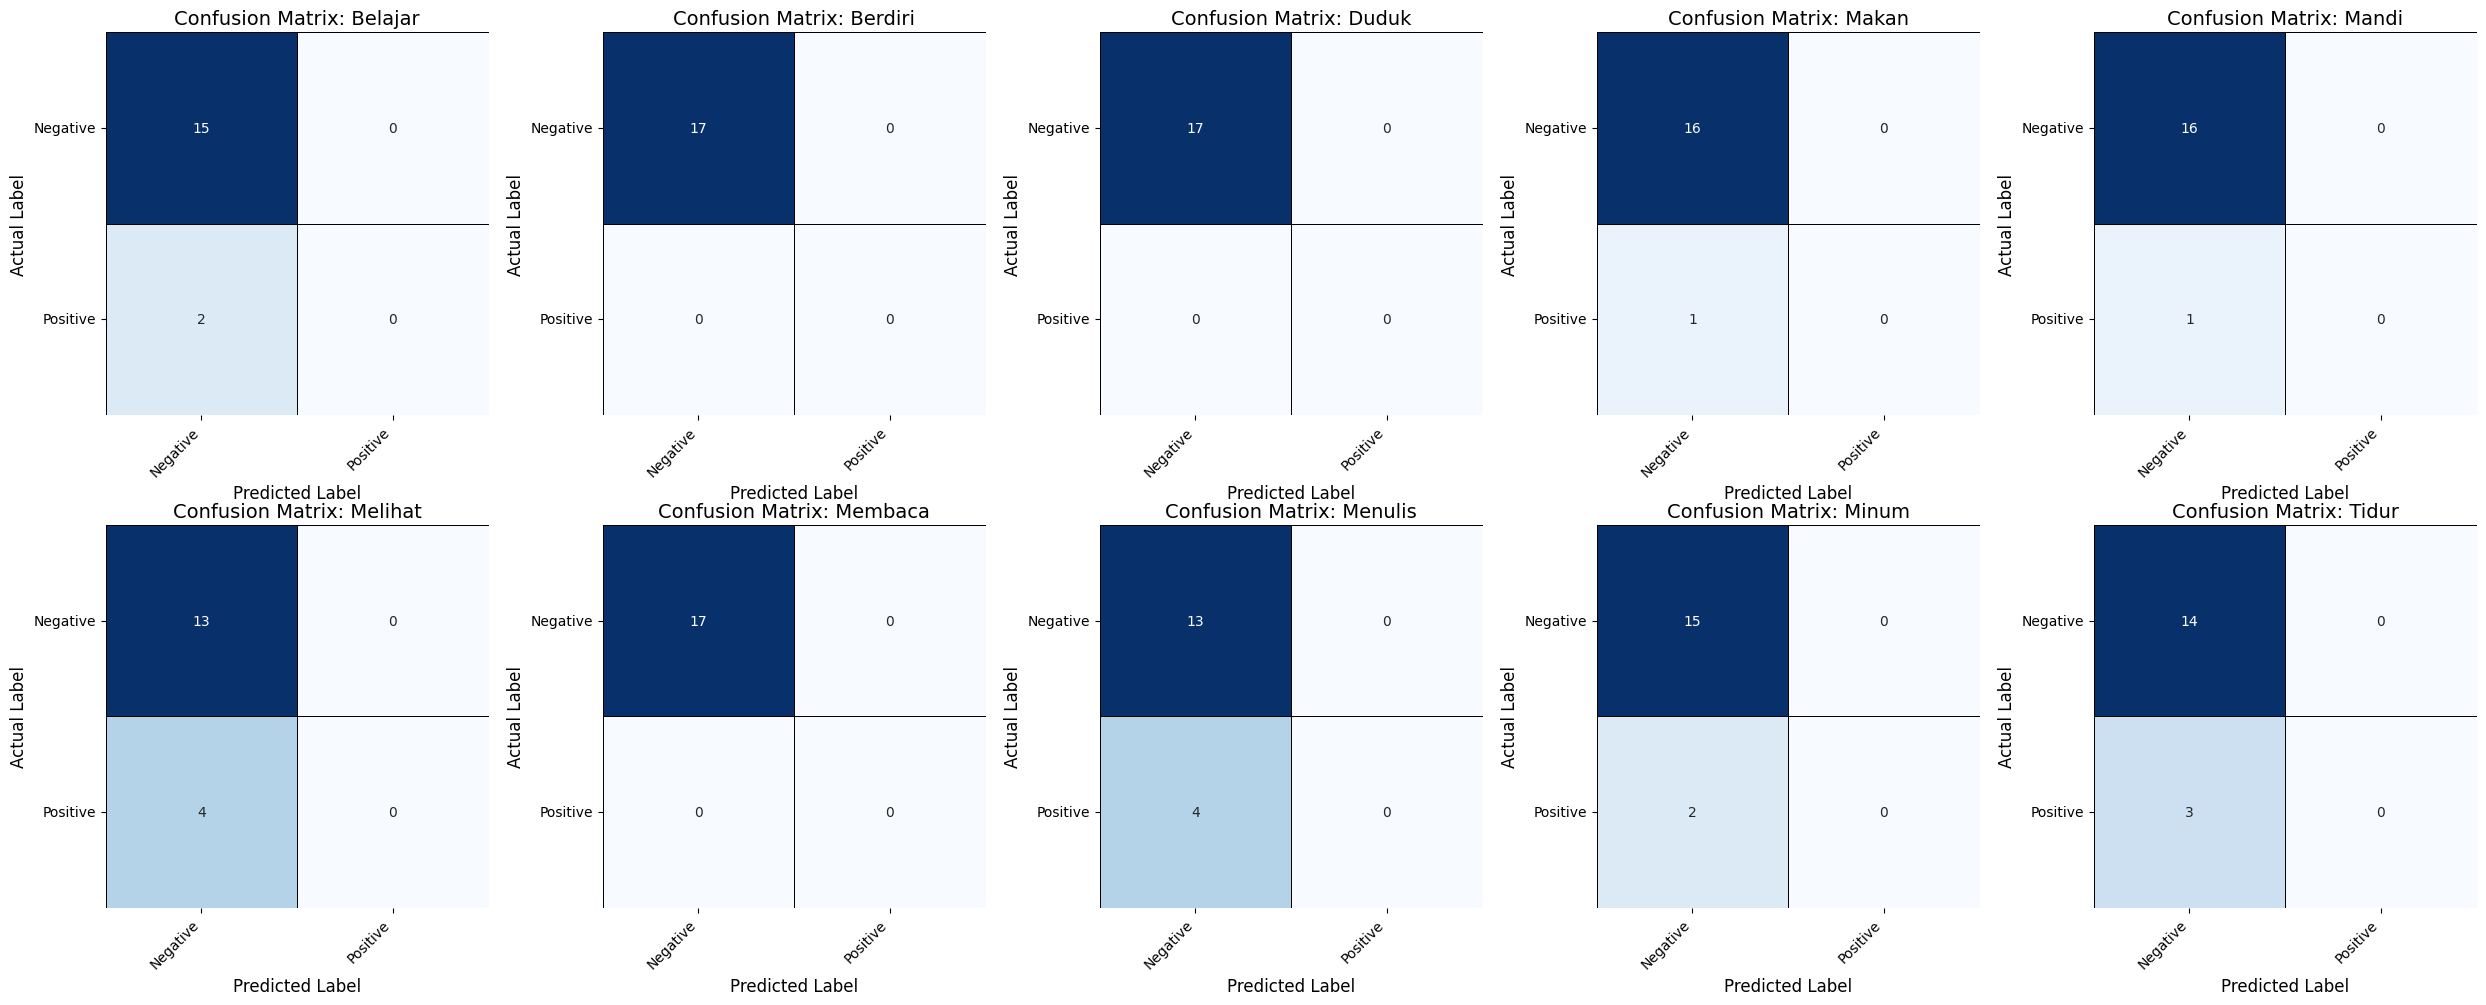

In [22]:
import numpy as np
import pandas as pd
# Asumsi model sudah di-import/didefinisikan di sel sebelumnya (misalnya model = load_model('action.keras'))
# Asumsi X_test dan y_test sudah didefinisikan dari train_test_split.
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# =======================================================
# 💡 KODE YANG HILANG/DIBUTUHKAN
# =======================================================

# 1. Definisikan Aksi (dari Cell 6 di BISINDO.ipynb)
actions = np.array(['Belajar','Berdiri','Duduk','Makan','Mandi','Melihat','Membaca','Menulis','Minum','Tidur'])

# 2. Lakukan Prediksi dan Binarisasi
try:
    # A. Hitung Probabilitas Mentah (Continuous-Multioutput)
    # Asumsi 'model' dan 'X_test' sudah didefinisikan.
    y_pred_proba = model.predict(X_test)

    # B. Binarisasi Prediksi (Mengubah ke Multilabel-Indicator)
    # Ini adalah langkah KRUSIAL untuk mengatasi ValueError.
    # Nilai di atas 0.5 diubah menjadi 1 (Positive), sisanya 0 (Negative).
    y_pred = np.where(y_pred_proba > 0.5, 1, 0)

except NameError as e:
    # Peringatan jika variabel yang diperlukan belum ada
    print(f"Error: {e}. Pastikan 'model', 'X_test', dan 'y_test' sudah didefinisikan dari sel-sel sebelumnya.")
    # Agar kode di bawah tidak error saat demonstrasi, kita akan raise error agar user melihat variabel apa yang kurang.
    raise

# =======================================================

# Calculate multilabel confusion matrix
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)
labels = ["Negative", "Positive"] # Labels for the 2x2 matrix

# Create a figure to hold all subplots (one for each class)
# You might adjust the figsize based on the number of classes ('actions')
num_classes = len(actions)
# Sesuaikan layout jika jumlah kelas lebih dari 5, misalnya 2 baris
rows = 2 if num_classes > 5 else 1
cols = (num_classes + 1) // rows
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))

# Handle the case where axes is not a flat array (1 row or 1 column)
if rows == 1 and cols > 1:
    axes = axes
elif rows > 1 and cols > 1:
    axes = axes.flatten()
elif num_classes == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, matrix in enumerate(conf_matrix):
    # Ambil subplot saat ini
    ax = axes[idx]

    # Buat heatmap menggunakan seaborn
    sns.heatmap(
        matrix,
        annot=True,              # Annotate the cells with the data values
        fmt="d",                 # Format the annotations as integers ('d' for decimal)
        cmap="Blues",            # Color map (e.g., 'Blues', 'YlGnBu')
        cbar=False,              # Don't show the color bar
        linewidths=.5,           # Add lines between cells
        square=True,             # Make cells square
        linecolor='black',
        ax=ax                    # Pass the specific subplot axis
    )

    # Set the labels and title for the specific heatmap
    ax.set_title(f'Confusion Matrix: {actions[idx]}', fontsize=14)
    ax.set_ylabel('Actual Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

    # Set the tick labels (for the 2x2 matrix)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_yticklabels(labels, rotation=0)

# Sembunyikan subplot kosong jika ada
for i in range(num_classes, rows * cols):
    fig.delaxes(axes[i])

# Adjust the layout to prevent titles/labels from overlapping
plt.tight_layout()

# Simpan dan Tampilkan plot
plt.savefig('multilabel_confusion_matrices.png')
# plt.show() # Di lingkungan notebook, plt.show() akan otomatis menampilkan plot
print("Confusion Matrices berhasil dihitung dan disimpan sebagai 'multilabel_confusion_matrices.png'")


# ... (rest of your code for accuracy_score) ...
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy Score: {accuracy:.4f}")

In [ ]:
model = tf.keras.models.load_model("my_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

with open("my_model.tflite", "wb") as f:
    f.write(tflite_model)